In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import warnings


warnings.filterwarnings("ignore")
sns.set_style('darkgrid')

## 0. Data preprocessing

Data focus mostly on checking the data - what they contain, in what form and in what number, and the beginning of the processing data for the model - deleting missing data and changing the label 'Irrelevant' to 'Neutral'.

In [33]:
# Load data
df = pd.read_csv('./data/twitter.csv', header=None, names=['id', 'entity', 'sentiment', 'content'])
df.head()

,id,entity,sentiment,content
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [34]:
# Drop null
print(df.shape)
df.dropna(inplace = True)
print(df.shape)

(75682, 4)
(74996, 4)


In [35]:
# Change Irrelevant to Neutral
print(df["sentiment"].unique())
df["sentiment"].replace({"Irrelevant": "Neutral"}, inplace=True)
print(df["sentiment"].unique())

['Irrelevant' 'Neutral' 'Negative' 'Positive']
['Neutral' 'Negative' 'Positive']


## 1. Data visualization

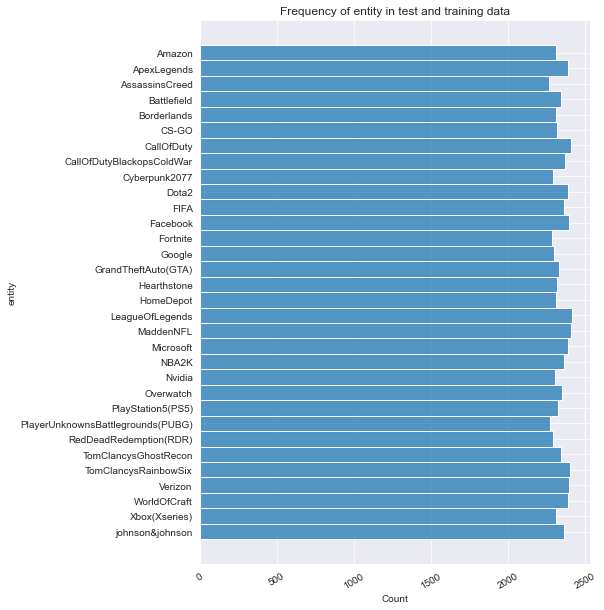

In [36]:
# # Horizontal histogram of entity
fig, ax1 = plt.subplots(figsize=(7, 10))
sns.histplot(data=df.sort_values(by=['entity']), y="entity", binwidth=5)
ax1.set_title('Frequency of entity in test and training data')
ax1.tick_params(axis='x', labelrotation=30)
plt.show()

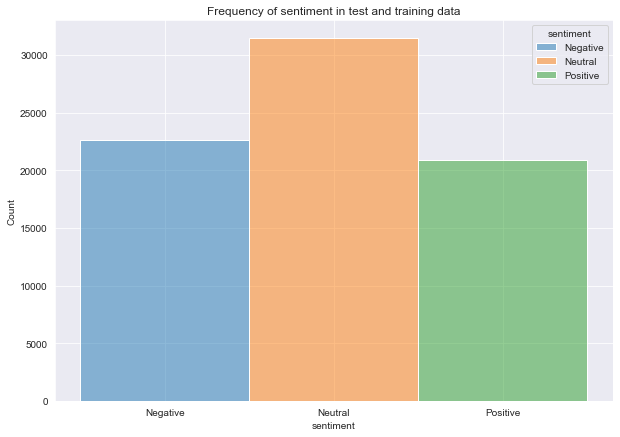

In [39]:
# Sentiment visualization
fig, ax1 = plt.subplots(figsize=(10, 7))
sns.histplot(data=df.sort_values(by=['sentiment']), x="sentiment", hue='sentiment', ax=ax1)
ax1.set_title('Frequency of sentiment in test and training data')
plt.show()

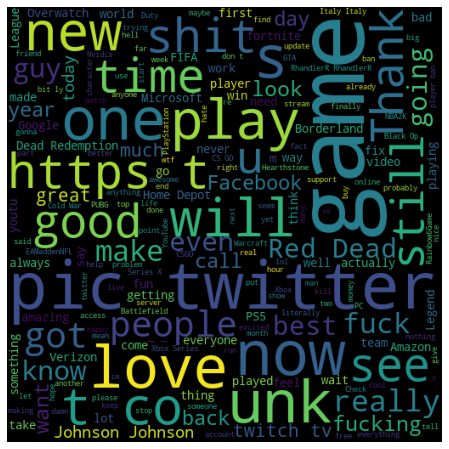

In [41]:
# Word cloud visualization

train_words = " ".join(list(df['content'] ))
train_plot = WordCloud(width = 512, height = 512).generate(train_words)

plt.figure(figsize=(10,8))
plt.imshow(train_plot)
plt.axis('off')
plt.show()

## 2. Data processing

In this part, the data will be prepared for use in models. To do this, the content of the data will be tokenized first, followed by stemming and vectorization of the data. In this section, you will also change the labels from words to numbers for easier use in model training and validation.

In [42]:
# Load tokenizer
import nltk
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')

from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\patry\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [43]:
# Vectorize content + stemming
stemmer = PorterStemmer()
vectorizer = CountVectorizer()
content_df = df["content"]
stemmed = [stemmer.stem(word) for word in content_df]
vectorizer.fit(stemmed)
transformed = vectorizer.transform(stemmed)
print(transformed.shape)

C:\Users\patry\miniconda3\envs\ml\lib\site-packages\sklearn\feature_extraction\text.py:1208: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


(74996, 32347)


In [45]:
# Change sentiment to values
# 0 = Neutral
# 1 = Positive
# 2 = Negative
df["sentiment"].replace({"Neutral": 0, "Positive": 1, "Negative": 2}, inplace=True)

print(df["sentiment"].unique())


[0 2 1]


## 3. Model training and evaluation

In [47]:
# split data to train and test
y = df["sentiment"]
X = transformed

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [49]:
def crossVal(model, X, Y): # X, Y - training data
  scores = cross_val_score(model, X, Y, cv=5)
  print(f'Cross validation for cv = 5:\n{scores}')
  print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

In [50]:
def printScores(model, X, Y): # X, Y - test data
    print("Mean Squared Error:")
    print(mean_squared_error(Y, model.predict(X)))
    print("Classification report:")
    print(classification_report(Y, model.predict(X)))
    print("Confusion matrix:")
    print(confusion_matrix(Y, model.predict(X)))

## 3.1 Naive Bayes

In [53]:
model = MultinomialNB()


# naucz klasyfikator na zbiorze uczącym
model = model.fit(X_train, y_train)
crossVal(model, X_train, y_train)
# wypisz wartości metryk
printScores(model, X_test, y_test)

Wyniki walidacji krzyżowe dla cv = 5:
[0.76914286 0.76552381 0.75492904 0.76769216 0.76502524]
0.76 accuracy with a standard deviation of 0.00
Mean Squared Error:
0.5013556158051469
Classification report:
              precision    recall  f1-score   support

           0       0.83      0.73      0.77      9385
           1       0.75      0.79      0.77      6312
           2       0.74      0.83      0.78      6802

    accuracy                           0.77     22499
   macro avg       0.77      0.78      0.77     22499
weighted avg       0.78      0.77      0.77     22499

Confusion matrix:
[[6845 1174 1366]
 [ 743 4956  613]
 [ 700  486 5616]]


## 3.2 Linear SVC

In [55]:
from sklearn.svm import LinearSVC

model = LinearSVC(max_iter=1000, dual=False)
# naucz klasyfikator na zbiorze uczącym
model = model.fit(X_train, y_train)
crossVal(model, X_train, y_train)
# wypisz wartości metryk
printScores(model, X_test, y_test)

C:\Users\patry\miniconda3\envs\ml\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Wyniki walidacji krzyżowe dla cv = 5:
[0.86190476 0.86       0.85922469 0.86436804 0.85474807]
0.86 accuracy with a standard deviation of 0.00
Mean Squared Error:
0.26174496644295303
Classification report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      9385
           1       0.86      0.86      0.86      6312
           2       0.89      0.87      0.88      6802

    accuracy                           0.87     22499
   macro avg       0.87      0.87      0.87     22499
weighted avg       0.87      0.87      0.87     22499

Confusion matrix:
[[8359  577  449]
 [ 605 5405  302]
 [ 574  313 5915]]


## 3.3 Logistic regression

Based on: https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-definitions

SAGA -the solver of choice for sparse multinomial logistic regression and it’s also suitable for very Large dataset.

Liblinear - applies automatic parameter selection (a.k.a L1 Regularization) and it’s recommended when you have high dimension dataset (recommended for solving large-scale classification problems)

In [56]:
print('SAGA')
model = LogisticRegression(solver='saga', max_iter=10000)
#naucz klasyfikator na zbiorze uczącym
model = model.fit(X_train, y_train)
crossVal(model, X_train, y_train)
# wypisz wartości metryk
printScores(model, X_test, y_test)


print('LIBLINEAR')
model = LogisticRegression(solver='liblinear', max_iter=10000)
#naucz klasyfikator na zbiorze uczącym
model = model.fit(X_train, y_train)
crossVal(model, X_train, y_train)
# wypisz wartości metryk
printScores(model, X_test, y_test)


SAGA
Wyniki walidacji krzyżowe dla cv = 5:
[0.83457143 0.82780952 0.82522145 0.83093628 0.82750738]
0.83 accuracy with a standard deviation of 0.00
Mean Squared Error:
0.33139250633361483
Classification report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      9385
           1       0.84      0.82      0.83      6312
           2       0.87      0.83      0.85      6802

    accuracy                           0.85     22499
   macro avg       0.85      0.84      0.84     22499
weighted avg       0.85      0.85      0.85     22499

Confusion matrix:
[[8233  647  505]
 [ 792 5151  369]
 [ 820  348 5634]]
LIBLINEAR
Wyniki walidacji krzyżowe dla cv = 5:
[0.83752381 0.83466667 0.82865035 0.84055624 0.83141252]
0.83 accuracy with a standard deviation of 0.00
Mean Squared Error:
0.3157918129694653
Classification report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      9385
           

## 3.4 Decision tree

In [57]:
model = DecisionTreeClassifier()
# naucz klasyfikator na zbiorze uczącym
model = model.fit(X_train, y_train)
crossVal(model, X_train, y_train)
# wypisz wartości metryk
printScores(model, X_test, y_test)
print(f'Depth of decision tree: {model.get_depth()}')

Wyniki walidacji krzyżowe dla cv = 5:
[0.80228571 0.7887619  0.78483665 0.78626536 0.79036099]
0.79 accuracy with a standard deviation of 0.01
Mean Squared Error:
0.3942397439886217
Classification report:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      9385
           1       0.81      0.76      0.79      6312
           2       0.83      0.80      0.81      6802

    accuracy                           0.81     22499
   macro avg       0.82      0.81      0.81     22499
weighted avg       0.81      0.81      0.81     22499

Confusion matrix:
[[8085  666  634]
 [1062 4813  437]
 [ 927  461 5414]]
Depth of decision tree: 890
